In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, precision_recall_curve

torch.manual_seed(420)

import warnings
warnings.filterwarnings("ignore")

# Postavka problema: Opstanak novih igrača u NBA ligi

Jedan od čestih problema menadžera timova u NBA ligi je procena da li je igrač koji je upravo došao u ligu ima potencijala da u njoj igra na duže staze. 
Menadžeri se pored mišljenja trenera i ostalih igrača vrlo često oslanjaju na analizu statistike igrača.
U ovom radu predlažemo model koji će na osnovu statistike prve sezone igrača u NBA generisati predlog da li je vredno zadržati igrača u timu.

Treniranje i evaluacija vršena je na datasetu [5 Year Survival of NBA Rookies from 1980-2015](https://www.kaggle.com/datasets/mamadoudiallo/5-year-survival-of-nba-rookies-from-19802015) u kojem je računata isplativost zadržavanja igrača u timu ako on i dalje ima ugovor nakon 5 godina po dolasku u ligu.
Dataset sadrži sve draftovane igrače u periodu od 1980. do 2015, njihovu statistiku u prvoj sezoni, kao i to da li su ostali u ligi nakon 5 godina.

# Istraživanje podataka i predprocesiranje

U nastavku su podaci učitani u *dataframe* i urađeno je osnovno predprocesiranje kako bi se smanjila dimenzionalnost problema.
Svaka od odluka pri filtriranju baze biće objašnjena neposredno pre ili posle odgovarajućeg bloka koda.

In [2]:
# Load .csv file into pandas dataframe
df = pd.read_csv("data/rookie_df.csv", low_memory=False)
df

,Unnamed: 0,Year Drafted,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,target
0,0,2013,70,34.5,16.7,6.1,15.1,40.5,0.8,3.0,...,70.3,1.4,4.8,6.2,6.3,1.9,0.6,3.5,17.6,1
1,1,2013,70,32.3,12.8,4.9,12.8,38.0,1.6,4.8,...,90.3,0.5,2.4,3.0,5.7,0.6,0.1,1.9,12.1,1
2,2,2013,80,31.1,13.8,4.9,11.7,41.9,0.9,2.8,...,78.0,0.5,3.6,4.1,4.1,1.6,0.5,3.2,13.2,1
3,3,2013,82,26.7,8.8,3.1,8.3,37.6,1.2,3.6,...,80.4,0.6,2.2,2.9,1.0,0.6,0.2,1.2,6.7,1
4,4,2013,77,24.6,6.8,2.2,5.4,41.4,0.5,1.5,...,68.3,1.0,3.4,4.4,1.9,0.8,0.8,1.6,9.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,1419,1980,59,10.1,3.2,1.4,3.1,45.4,0.0,0.1,...,56.4,0.5,0.6,1.0,1.2,0.6,0.1,1.3,2.8,0
1420,1420,1980,47,9.6,2.0,0.7,2.0,35.8,0.0,0.1,...,78.1,0.2,0.7,0.9,1.5,0.5,0.0,0.6,2.9,1
1421,1421,1980,60,8.9,2.8,1.0,3.0,33.0,0.0,0.1,...,73.9,0.5,0.7,1.2,1.3,0.4,0.0,0.6,2.7,0
1422,1422,1980,55,8.4,2.7,1.0,2.5,41.2,0.0,0.1,...,43.5,0.5,1.2,1.7,0.3,0.4,0.4,0.6,2.6,0


In [3]:
# Print all column names
df.columns

Index(['Unnamed: 0', 'Year Drafted', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%',
       '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'STL', 'BLK', 'TOV', 'EFF', 'target'],
      dtype='object')

### Odabir relevantnih atributa

U datasetu postoji 22 atributa za svakiog igraca, medju kojima postoje neki koji su očigledno korelisani.
Uzmimo za primer slobodna bacanja: za svakog igrača je vođena statistika koliko bacanja je igrač šutira (`FGA`), koliko ih je pogodio (`FGM`), kao i procenat uspešnih bacanja (`FG%`).
Očigledno je da je procenat moguće nedvosmisleno iračunati iz prva dva podatka, tako da je on otklonjen.
Odluka da se zadže dva broja umesto procenta doneta je kako bi model mogao da uračuna situacije u kojima je igrač imao mali broj pokušaja i samim time procenat ne prenosi adekvatno njegovu stvarnu efikasnost.

U nastavku je zadržano 16 atributa i otklonjeni su svi igrači sa nedefinisanim poljima.

| Atribut | Opis                                        |
|---------|---------------------------------------------|
| GP      | Broj odigranih utakmica                     |
| MIN     | Prosečan broj minuta u igri                 |
| PTS     | Prosečan broj postignutih poena             |
| FGM     | Prosečan broj postignutih šuteva iz igre    |
| FGA     | Prosečan broj pokušanih šuteva iz igre      |
| 3P Made | Prosečan broj postignutih šuteva za 3 poena |
| 3PA     | Prosečan broj pokušanih šuteva za 3 poena   |
| FTM     | Prosečan broj pogođenih slobodnih bacanja   |
| FTA     | Prosečan broj pokušanih slobodnih bacanja   |
| OREB    | Prosečan broj skokova u napadu              |
| DREB    | Prosečan broj skokova u odbrani             |
| AST     | Prosečan broj asistencija                   |
| STL     | Prosečan broj ukradenih lopti               |
| BLK     | Prosečan broj blokiranih šuteva             |
| TOV     | Prosečan broj izgubljenih lopti             |
| EFF     | Prosečan skor efikasnosti igrača            |

In [4]:
# Choose valuable features
clean_df = df[['GP', 'MIN', 'PTS', 'FGM', 'FGA',
       '3P Made', '3PA', 'FTM', 'FTA', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'EFF', 'target']].copy()
clean_df.dropna(inplace=True)

In [5]:
# Describe features
clean_df.describe()

,GP,MIN,PTS,FGM,FGA,3P Made,3PA,FTM,FTA,OREB,DREB,AST,STL,BLK,TOV,EFF,target
count,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000
mean,61.131320,17.483216,6.735323,2.602247,5.799930,0.238062,0.740520,1.295084,1.822121,1.034059,2.041011,1.497331,0.601826,0.388764,1.188062,7.381461,0.601124
std,16.828774,8.265126,4.324453,1.666493,3.545943,0.385139,1.057448,0.981904,1.322281,0.786525,1.371742,1.445766,0.406427,0.471463,0.714481,4.621797,0.489839
min,11.000000,3.100000,0.700000,0.300000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.100000,0.200000,0.000000
25%,48.000000,10.900000,3.600000,1.400000,3.200000,0.000000,0.000000,0.600000,0.900000,0.500000,1.000000,0.500000,0.300000,0.100000,0.700000,3.800000,0.000000
50%,64.000000,15.950000,5.500000,2.100000,4.800000,0.000000,0.200000,1.000000,1.500000,0.800000,1.700000,1.000000,0.500000,0.200000,1.000000,6.350000,1.000000
75%,77.000000,23.000000,8.800000,3.400000,7.500000,0.300000,1.100000,1.700000,2.300000,1.400000,2.700000,1.900000,0.800000,0.500000,1.500000,9.800000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,2.300000,6.500000,7.700000,10.200000,5.400000,9.600000,10.600000,2.500000,5.000000,4.400000,30.600000,1.000000


In [6]:
# Calculate percentage of True datapoints
value_cnts = clean_df["target"].value_counts()
print(f"Dataset sadrži {len(clean_df)} igrača od kojih je {value_cnts[1] / len(clean_df) * 100:0.2f}% ostalo u ligi nakon 5 godina.")

Dataset sadrži 1424 igrača od kojih je 60.11% ostalo u ligi nakon 5 godina.


### Podela na trening i test

Dataset je podeljen na trening i test skup, od čega trening set sadrži 70% podataka.
Korištena je fukncija `train_test_split` koja nasumično promeni mesta podataka u tabeli pre nego što uradi podelu na dva seta. 

In [7]:
from sklearn.model_selection import train_test_split

# Do train/test split
train_df, valid_df = train_test_split(clean_df, train_size=.7, random_state=420)

### Normalizacija dataseta

Pošto se svi atributi u datasetu ne nalaze u istim opsezima, izvršena je normalizacija podataka.
Za ovu svrhu upotrebljena je `StandardScaler` klasa, ima mogućnost fitovanja parametara normalizacije na jednom skupu, i odvojenu primenu iste.
Parametri normalizacije su fitovani na trening setu, a onda primenjeni i na treningu i na testu.
Na ovaj način nije došlo do curenja informacija iz testa u trening.

In [8]:
from sklearn.preprocessing import StandardScaler

input_columns = clean_df.columns[:-1]

# Fit scaler
scaler = StandardScaler()
scaler.fit(train_df[input_columns].values)

# Normalize train data
norm_train_np = scaler.transform(train_df[input_columns].values)
norm_train_df = pd.DataFrame(norm_train_np, columns=input_columns)
norm_train_df["target"] = train_df["target"].values

# Normalize validation data
norm_valid_np = scaler.transform(valid_df[input_columns])
norm_valid_df = pd.DataFrame(norm_valid_np, columns=input_columns)
norm_valid_df["target"] = valid_df["target"].values

Ovime je završeno predprocesiranje podataka, i oni su spremni za treniranje modela.

# Definisanje modela

Radi predikcije dugovečnosti igrača na osnovu statistike u prvoj godini implementirana je poptpuno povezana neuronska mreža.
Mrežu je moguće inicilaizovati sa proizvoljnim brojem skrivenih slojeva, a postoji tačno jedan izlazni neuron.
Izlaz modela predstavlja njegovo poverenje da će igrač opstati u ligi, u rasponu [0, 1].

Svi delovi generisanja modela, treninga i evaluacije dekomponovani su u odgovarajuće funkcije i klase radi jednostavnijeg eksperimentisanja kasnije.

### Klasa za učitavanje podataka

Tokom treninga je poželjno da pri tokom svake epohe treninga, podaci budu prosleđeni modelu u različitim redosledima.
`pytorch` obezbeđuje ovu funkcionalnost, kao i jednostavno čitanje podataka po *batch*-evima iteracijom kroz klasu `Dataloader`.
Ova klasa pri svojoj inicijalizaciji zahteva objekat koji nasleđuje klasu `Dataset`.

`Dataset` je klasa koja sadrži sve podatke treninga/testa i potrebno je u njoj implementirati metod `__getitem__` koji vraća ulazne podatke kao i očekivanu vrednost za model, na osnovu indeksa u bazi.
U nastavku je implementirana klasa `NBA_Dataset`, koja obezbeđuje ovu funkcionalnost za odgovarajući dataset.

In [9]:
from torch.utils.data import Dataset, DataLoader

class NBA_Dataset(Dataset):
    """Class for holding data NBA rookie statistics, and if they remained in the league after 5 year ."""

    def __init__(self, df: pd.DataFrame) -> None:
        """Initialize torch Dataset based on pandas Dataframe."""
        super(NBA_Dataset, self).__init__()

        # Take all except the last column as inputs
        self.inputs = df.values[:, :-1].astype(float)

        # Cast Targets column to numpy
        self.targets = df["target"].values.astype(int)

        # Save dataframe as part of the class
        self.df = df

        # Define dataset length
        self.len = len(df)

    def __getitem__(self, index) -> dict:
        """Return dict with information of datapoint at `index`"""
        # Get input
        input_row = torch.Tensor(self.inputs[index, :])

        # Get output
        target = torch.Tensor([self.targets[index]])

        return {
            "Inputs": input_row,
            "Targets": target,
        }

    def __len__(self):
        """Get dataset length."""
        return self.len

Nakon inicijalizacije `Dataset` klase, ona je *wrap*-ovana u `Dataloader` klasu.
U okviru ove klase su definisane veličina *batch*-a, broj radnih jedinica, kao i opcija da li redosled podataka treba randomizovati pred svaku epohu.

In [10]:
train_dataset = NBA_Dataset(train_df)

train_parameters = {
    "batch_size": 64,
    "shuffle": True,
    "num_workers": 1,
}

training_loader = DataLoader(train_dataset, **train_parameters)

# Validation dataset
valid_dataset = NBA_Dataset(valid_df)

valid_parameters = {
    "batch_size": 64,
    "shuffle": False,
    "num_workers": 1,
}

validation_loader = DataLoader(valid_dataset, **valid_parameters)

### Arhitektura modela

Model je implementiran u klasi `NBA_Survival_Predictor`.
Mrežu je moguće inicijalizovati sa proizvoljnim brojem skrivenih slojeva, čije se veličine prosleđuju konstruktoru u vidu liste.
Model je takođe moguće inicijalizovati sa proizvoljnom aktivacionom funkciojom, a ako ona nije prosleđena, aktivaciona fukcija će biti hiperbolički tangens.

U okviru `forward` funkcije implementiran je prolazak kroz model.
Podaci se provlače kroz sve inicijalizovane objekte u listi slojeva.
Objekti su naizmenično potpuno povezani slojevi i aktivacione funkcije, a umesto poslednje aktivacione funkcije primenjen sigmoid.
Sigmoidna funkcija je upotrebljena kao standardna aktivaciona funkcija izlaznog sloja, prilikom klasifikacionih problema.

In [11]:
import torch.nn as nn

class NBA_Survival_Predictor(nn.Module):
    """Class for estimating chance of NBA rookie surviving in the league."""

    def __init__(self, layer_sizes: list, activation_function: nn.Module = None) -> None:
        """Initialize fully-connected model based on input parameters."""
        super(NBA_Survival_Predictor, self).__init__()

        # Check if input and output layers are passed
        assert len(layer_sizes) >= 2

        # Check if activation function is not passed
        if activation_function is None:
            activation_function = nn.ReLU()

        # Define activation function
        self.activation = activation_function

        # Initialize list of layers
        layer_list = []

        # Initialize each layer and activation function
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer_list.append(nn.Linear(in_size, out_size))
            layer_list.append(nn.Tanh())

        # Cast layer list to nn.Module
        self.fc_layers = nn.ModuleList(layer_list)

    def forward(self, X) -> torch.Tensor:
        """Define network behavior when called on data."""
        # Pass data trough fully-connected layers
        # Skip last activation function
        for layer in self.fc_layers[:-1]:
            X = layer(X)
        
        # Calculate output probability as sigmoid of output
        output_probability = torch.sigmoid(X)

        return output_probability

### Definisanje treninga i evaluacije

U nastavku se nalazi implementacija funkcije za treniranje i evaluaciju modela.
Funkciji od ulaznih parametara očekuje model, optimizator i DICTIONARY trenaznih objekata.
DICTIONARY u sebi sadrži 4 polja, *loss* funkciju, *dataloader* za trening i validaciju, kao i broj epoha za trening.

U okviru funkcije, model je treniran po *batch*-evima, a zatim evaluiran.
Na kraju svake epohe, sačuvani su vrednost *loss*-a i tačnost modela.
Tačnost je odabrana kao glavna metrika performanse modela zato što je *dataset* balansiran.

In [12]:
CLASS_THR = .5
def train_network(model: NBA_Survival_Predictor, optimizer: torch.optim.Optimizer, training_objects: dict) -> tuple:
    """Function trains and evaluates defined model using given optimizer on passed training objects.

    Returned values of the function are trained model, and a dictionary with training and evaluation
    metrics.

    Args:
        model (NBA_Survival_Predictor): Model for training.
        optimizer (torch.optim.Optimizer): Model optimizer.
        training_objects (dict): Dictionary containing loss function, number of epochs, and
                                 training and validation loaders.

    Returns:
        tuple: Passed model after training, and dictionary containing training and validation metrics.
    """

    # Unpack dictionaries
    loss_function = training_objects["Loss Function"]
    training_loader = training_objects["Train Dataloader"]
    validation_loader = training_objects["Valid Dataloader"]
    num_of_epochs = training_objects["Epochs"]

    # Initialize lists for logging training and validation metrics
    training_loss = []
    training_acc = []
    validation_loss = []
    validation_acc = []

    # Train model for set number of epochs
    for _ in range(num_of_epochs):

        # Reset training metrics
        train_epoch_loss = 0.0
        train_epoch_acc = 0.0

        # Set model in train mode
        model.train()

        # Loop over training set in batches
        for batch in training_loader:
            
            # Unpack batch
            X = batch["Inputs"]
            Y = batch["Targets"]

            # Reset optimizer gradients
            optimizer.zero_grad()

            # Run a forward pass
            probabilities = model(X)

            # Calculate loss
            loss = loss_function(probabilities, Y)
            train_epoch_loss += loss.item()

            # Update model
            loss.backward()
            optimizer.step()

            # Calculate predictions
            predictions = probabilities >= CLASS_THR

            # Log true predictions
            train_epoch_acc += sum(predictions == Y)

        # Calculate epoch metrics
        train_epoch_loss /= len(training_loader)
        train_epoch_acc /= len(training_loader.dataset)

        # Log epoch metrics
        training_loss.append(train_epoch_loss)
        training_acc.append(train_epoch_acc)

        # Reset validation metrics
        valid_epoch_loss = 0.0
        valid_epoch_acc = 0.0

        # Set model in evaluation mode
        model.eval()

        # Loop over validation set in batches
        for batch in validation_loader:
            
            # Unpack batch
            X = batch["Inputs"]
            Y = batch["Targets"]

            # Run forward pass
            probabilities = model(X)

            # Calculate loss
            loss = loss_function(probabilities, Y)
            valid_epoch_loss += loss.item()

            # Calculate predictions
            predictions = probabilities >= CLASS_THR

            # Log true predictions
            valid_epoch_acc += sum(predictions == Y)

        # Calculate validation metrics
        valid_epoch_loss /= len(validation_loader)
        valid_epoch_acc /= len(validation_loader.dataset)

        # Log validation metrics
        validation_loss.append(valid_epoch_loss)
        validation_acc.append(valid_epoch_acc)

    # Get metrics and prediction probabilities of final model
    probabilities = []
    predictions = []
    targets = []

    # Evaluate final model
    for batch in validation_loader:
        
        # Load batch
        X = batch["Inputs"]
        Y = batch["Targets"]

        # Run forward pass
        batch_probabilities = model(X)
        batch_predictions = batch_probabilities >= CLASS_THR

        # Log probabilities, predictions and targets
        probabilities.extend(batch_probabilities.detach().numpy().flatten().tolist())
        predictions.extend(batch_predictions.detach().numpy().flatten().tolist())
        targets.extend(Y.detach().numpy().flatten().tolist())

    # Pack all results in a dictionary
    training_parameters = {
        "train loss": training_loss,
        "train acc": training_acc,
        "validation loss": validation_loss,
        "validation acc": validation_acc,
        "Prediction probabilities": probabilities,
        "Predictions": predictions,
        "Targets": targets,
    }

    return model, training_parameters

# Treniranje različitih modela

U ovom odeljku je definisano tri modela iste arhitekture, ali sa drugačijim hiperparametrima.
Za *loss* funkciju izabrana je **binarna krosentropija**, pošto rezultati predstavljaju klasifikaciju igrača u dve klase (opstaće/neće opstati u ligi).

Od optimizacionih funkcija, eksperimentisano je sa **stohastičkim gradijentalnim spustom** i **Adamovim optimizatorem**.
Adam je pokazao konstantno bolje rezultate, pa je on korišten za sve primere.

Svi modeli su trenirani na istom datasetu, istim redosledom batcheva i na **400 epoha**.

U nastavku su definisane tri arhitekture: jedna koja je nedovoljno obučena, jedna koja je preobučena, i jedna koja je adekvatna.
Slede definicije modela, njihovi treninzi i performanse.

In [13]:
from torch.nn import BCELoss
from torch.optim import Adam, SGD

# Initialize loss function as Binary Cross Entropy
loss_function = BCELoss()

# Define learning rate
lr = 3e-4

# Define number of epochs
num_of_epochs = 400

# Wrap training loaders into dictionary
training_objects = {
    "Loss Function": loss_function,
    "Train Dataloader": training_loader,
    "Valid Dataloader": validation_loader,
    "Epochs": num_of_epochs,
}

### Definicija, trening i evaluacija

#### Treniranje modela sa premalom arhitekturom

In [14]:
# Define model with no hidden layers
underfit_model = NBA_Survival_Predictor([train_dataset.inputs.shape[1], 1])

# Define optimizer for model with 5 times smaller learning rate
underfit_optimizer = Adam(params=underfit_model.parameters(), lr=lr/5)

# Train and evaluate model
underfit_model, underfit_results = train_network(underfit_model, underfit_optimizer, training_objects=training_objects)

#### Treniranje modela sa prevelikom arhitekturom

In [15]:
# Define model with 2 hidden layers
overfit_model = NBA_Survival_Predictor([train_dataset.inputs.shape[1], 20, 4, 1])

# Define optimizer for model with 3 times bigger learning rate
overfit_optimizer = Adam(params=overfit_model.parameters(), lr=lr*3)

# Train and evaluate model
overfit_model, overfit_results = train_network(overfit_model, overfit_optimizer, training_objects=training_objects)

#### Treniranje modela sa adekvatnom arhitekturom

In [16]:
# Define model with 1 hidden layer
overfit_model = NBA_Survival_Predictor([train_dataset.inputs.shape[1], 15, 1])

# Define optimizer for model with original learning rate
overfit_optimizer = Adam(params=overfit_model.parameters(), lr=lr)

# Train and evaluate model
final_model, final_results = train_network(overfit_model, overfit_optimizer, training_objects=training_objects)

### Prikaz rezultata treninga i validacije

Prikazani su rezultati za sva tri modela.
U prvom redu su prikazane vrednosti *loss* funkcije po epohama, za validaciju i trening.
U drugom redu su prikazane tačnosti modela na treningu i validaciji po epohama.
U trećem redu grafika su postavljene konfuzione matrice na validacionom setu na kraju treninga.

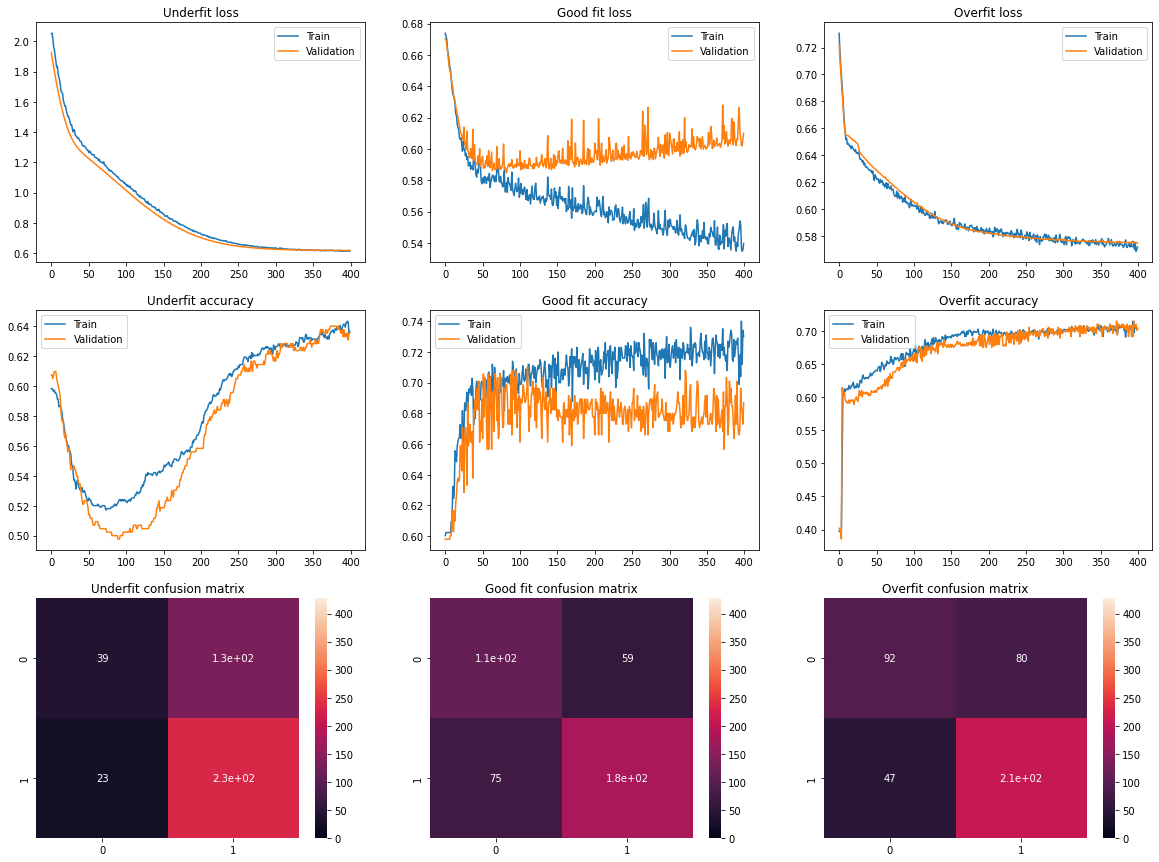

In [17]:
# Initialize 3x3 subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

# Initialize graph column names
title_labels = ["Underfit", "Good fit", "Overfit"]

# Loop over each column and generate graphs
for idx, results in enumerate([underfit_results, overfit_results, final_results]):

    # Plot loss
    ax[0, idx].plot(results["train loss"], label="Train")
    ax[0, idx].plot(results["validation loss"], label="Validation")
    ax[0, idx].legend()
    ax[0, idx].set_title(f"{title_labels[idx]} loss")

    # Plot accuracy
    ax[1, idx].plot(results["train acc"], label="Train")
    ax[1, idx].plot(results["validation acc"], label="Validation")
    ax[1, idx].legend()
    ax[1, idx].set_title(f"{title_labels[idx]} accuracy")

    # Plot confusion matrix
    sb.heatmap(confusion_matrix(results["Targets"], results["Predictions"]), vmin=0, vmax=len(validation_loader.dataset), annot=True, ax=ax[2, idx])
    ax[2, idx].set_title(f"{title_labels[idx]} confusion matrix")

Na graficima se može primetiti karakteristično ponašanje za sva tri modela.

Model bez skrivenih slojeva nije dovoljno kompleksan da bi efikasno vršio predviđanja.
Ovo se oslikava u funkciji tačnosti po epohama koja ne uspeva da pređe tačnost nasumičnog predviđanja (~60%).

Model sa 2 skrivena sloja preobučava.
Očigledan simptom preobučavanja su funkcije *loss*-a i tačnosti na validaciji i treningu, koje posle 50. epohe počinju sve više da se udaljavaju jedna od druge.

Model sa 1 skrivenim slojem pokazuje najbolje performanse.
Funkcije treninga i validacije imaju isti oblik i polako rastu kroz epohe.
*Loss* funkcije imaju željenu eksponencijalnu raspodelu.

Zbog male veličine modela, trening za sva tri traje slično vreme, oko minut i 30 sekundi.

### Preciznost/Odziv krive najboljeg modela

Nakon odabira najboljeg modela, menjan je prag odsecanja i analizirani su preciznost i odziv modela.

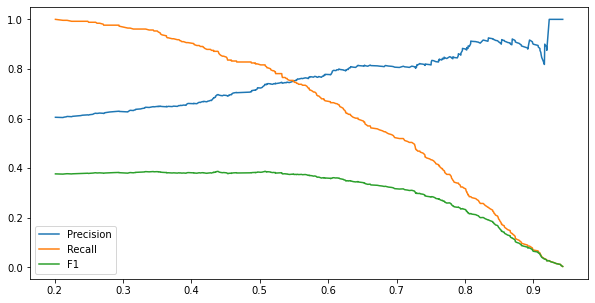

In [18]:
# Generate precision and recall curve points
prec, recall, thrs = precision_recall_curve(final_results["Targets"], final_results["Prediction probabilities"])

# Calculate f1-score
f1 = prec * recall / (prec + recall)

# Plot precision/recall/f1 curves
_, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(thrs, prec[:-1], label="Precision")
plt.plot(thrs, recall[:-1], label="Recall")
plt.plot(thrs, f1[:-1], label="F1")
plt.legend()
plt.show()

**DODAJ ANALIZU KAD SE IZVRSI**

# Automatsko traženje hyperparametara

Nakon ručnog odabira hiperparametara, implementirana je automatska pretraga.
U ovu svrhu upotrebljena je biblioteka ```optuna```, koju je koristiti sa već implementiranim modelom bez izmena.

Biblioteka radi generisanjem *study* sesije, kojoj treba zadati fukciju koju treba optimizovati.
Ova funkcija se definiše odvojeno, i u njoj je moguće generisati hiperparametre iz proizvoljne raspodele i nakon toga trenirati tako definisan model.

*Study* sesiji se takođe prosleđuje i sampler.
Cilj samplera je blago menjanje funkcija raspodela za odabir hiperparametara u zavisnosti od njihove performanse tokom sesije.

In [19]:
import optuna

### Funkcija cilja

U funkciji cilja su birani *learning rate*, broj skrivenih slojeva, kao i veličina svakog od skrivenih slojeva.
*Learning rate* je biran iz raspodele koja je uniformna na logaritamskoj skali u rasponu od $10^{-6}$ do $10^{-4}$.
Broj skrivenih slojeva je biran nasumično između 1, 2, 3 i 4, a svaki layer ima između 3 i 20 neurona.

Rezultat funkcije cilja je maksimalna tačnost na validaciji modela.

In [20]:
def objective_function(trial: optuna.trial.Trial):

    lr = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
    num_of_layers = trial.suggest_int("num_of_layers", 1, 4)

    layer_sizes = [train_dataset.inputs.shape[1]]

    for idx in range(num_of_layers):
        layer_sizes.append(trial.suggest_int(f"layer_{idx}", 3, 20))
    layer_sizes.append(1)

    model = NBA_Survival_Predictor(layer_sizes)
    optimizer = Adam(model.parameters(), lr=lr)

    training_objects["Epochs"] = 500

    _, results = train_network(model, optimizer, training_objects)

    return max(results["validation acc"])

In [21]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective_function, n_trials=100)

[I 2022-07-04 14:18:50,203] A new study created in memory with name: no-name-3fe7a150-244a-4a0b-aa25-27e2300d9520
[I 2022-07-04 14:20:39,116] Trial 0 finished with value: 0.6214953064918518 and parameters: {'learning_rate': 5.1256435759251725e-06, 'num_of_layers': 1, 'layer_0': 20}. Best is trial 0 with value: 0.6214953064918518.
[I 2022-07-04 14:22:25,389] Trial 1 finished with value: 0.6098130941390991 and parameters: {'learning_rate': 1.4756188421382837e-05, 'num_of_layers': 1, 'layer_0': 10}. Best is trial 0 with value: 0.6214953064918518.
[I 2022-07-04 14:24:21,705] Trial 2 finished with value: 0.6098130941390991 and parameters: {'learning_rate': 1.4243037860201327e-05, 'num_of_layers': 3, 'layer_0': 19, 'layer_1': 16, 'layer_2': 10}. Best is trial 0 with value: 0.6214953064918518.
[I 2022-07-04 14:26:16,016] Trial 3 finished with value: 0.6028037667274475 and parameters: {'learning_rate': 5.020369976240081e-06, 'num_of_layers': 1, 'layer_0': 10}. Best is trial 0 with value: 0.621

## Redukcija dimenzionalnosti

In [ ]:
cov_mat = clean_df.corr().to_numpy()[:-1, :-1]

# Calculate eig
eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

# Sort indexes

# Take vector subset
num_of_components = 5
eigv_subset = eigen_vectors[:, -num_of_components:]

# # Reduce X
# X_reduced = np.dot(eigv_subset.T, X.T).T

In [ ]:
X = clean_df.to_numpy()[:, :-1]

X_reduced = np.dot(eigv_subset.T, X.T).T
X_reduced.shape

(1424, 5)

In [ ]:
reduced_df = pd.DataFrame(X_reduced, columns=[f"f{idx}" for idx in range(num_of_components)])
reduced_df["target"] = clean_df["target"]
reduced_df

,f0,f1,f2,f3,f4,target
0,32.720628,-54.814642,-1.875326,2.777260,-48.837056,1
1,32.526022,-56.727047,-0.624926,5.207448,-41.031737,1
2,38.117593,-63.672355,-2.190177,2.440594,-44.525804,1
3,39.768680,-66.777725,-0.513493,2.264519,-35.606190,1
4,35.700192,-63.340263,-1.817067,-0.174656,-33.835434,1
...,...,...,...,...,...,...
1419,28.362832,-48.242262,-3.141612,-0.148563,-19.467689,0
1420,22.049302,-38.856705,-2.616861,0.004085,-15.836670,1
1421,29.180113,-48.797378,-3.180166,-0.383590,-19.061732,0
1422,26.768268,-44.703373,-2.267087,-0.982788,-17.713347,0
